# Taller 4 - Alternativo - Flujo SVHN
- Sebastián Castellano Estupiñan
- Ricardo Andrés Cortés Coronell
- Andrés Felipe Sanchez Rincón

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt

c:\Users\ASUS Vivobook\anaconda3\envs\BigDataPipelines\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\ASUS Vivobook\anaconda3\envs\BigDataPipelines\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\ASUS Vivobook\anaconda3\envs\BigDataPipelines\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

In [2]:
# Cargar el dataset SVHN
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'svhn_cropped',
    split=['train[:80%]', 'train[80%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

c:\Users\ASUS Vivobook\anaconda3\envs\BigDataPipelines\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 100%|██████████| 3/3 [04:16<00:00, 85.49s/ url] 


Dataset svhn_cropped downloaded and prepared to C:\Users\ASUS Vivobook\tensorflow_datasets\svhn_cropped\3.1.0. Subsequent calls will reuse this data.


In [3]:
# Función de normalización
def normalize_img(image, label):
    """Normaliza imágenes: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0, label

# Preparar los datasets
BATCH_SIZE = 128
BUFFER_SIZE = int(ds_info.splits['train'].num_examples * 0.8)

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [4]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(32, 32, 3)))

    # Ajuste del número de filtros en la primera capa convolucional
    hp_filters_1 = hp.Int('filters_1', min_value=32, max_value=64, step=32)
    model.add(layers.Conv2D(filters=hp_filters_1, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Ajuste del número de filtros en la segunda capa convolucional
    hp_filters_2 = hp.Int('filters_2', min_value=64, max_value=128, step=32)
    model.add(layers.Conv2D(filters=hp_filters_2, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Ajuste del número de unidades en la capa densa
    hp_units = hp.Int('units', min_value=64, max_value=256, step=64)
    model.add(layers.Dense(units=hp_units, activation='relu'))

    model.add(layers.Dense(10, activation='softmax'))

    # Ajuste de la tasa de aprendizaje
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
    
    return model

In [5]:
tuner = kt.Hyperband(build_model,
                        objective='val_accuracy',
                        max_epochs=10,
                        factor=3,
                        directory='svhn_tuning',
                        project_name='svhn_hyperparameter_tuning')

# Callback para detener el entrenamiento si no hay mejora
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Iniciar la búsqueda
tuner.search(ds_train, epochs=20, validation_data=ds_val, callbacks=[stop_early])

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
La búsqueda ha finalizado.
Filtros óptimos en la Capa 1: {best_hps.get('filters_1')}
Filtros óptimos en la Capa 2: {best_hps.get('filters_2')}
Unidades óptimas en la Capa Densa: {best_hps.get('units')}
Tasa de aprendizaje óptima: {best_hps.get('learning_rate')}
""")

Trial 30 Complete [00h 02m 11s]
val_accuracy: 0.8481332063674927

Best val_accuracy So Far: 0.897071897983551
Total elapsed time: 01h 02m 08s

La búsqueda ha finalizado.
Filtros óptimos en la Capa 1: 64
Filtros óptimos en la Capa 2: 128
Unidades óptimas en la Capa Densa: 256
Tasa de aprendizaje óptima: 0.001



Epoch 1/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 53s 91ms/step - accuracy: 0.6497 - loss: 1.0917 - val_accuracy: 0.8190 - val_loss: 0.6455
Epoch 2/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 52s 91ms/step - accuracy: 0.8591 - loss: 0.5025 - val_accuracy: 0.8562 - val_loss: 0.5185
Epoch 3/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 52s 91ms/step - accuracy: 0.8823 - loss: 0.4136 - val_accuracy: 0.8690 - val_loss: 0.4614
Epoch 4/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - accuracy: 0.8965 - loss: 0.3567 - val_accuracy: 0.8747 - val_loss: 0.4355
Epoch 5/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 51s 89ms/step - accuracy: 0.9076 - loss: 0.3164 - val_accuracy: 0.8822 - val_loss: 0.4174
Epoch 6/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - accuracy: 0.9173 - loss: 0.2827 - val_accuracy: 0.8801 - val_loss: 0.4206
Epoch 7/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - accuracy: 0.9256 - loss: 0.2552 - val_accuracy: 0.8784 - val_loss: 0.4348
Epoch 8/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 52s 90ms/step - accuracy: 0.9316 - loss: 0.2302 - 

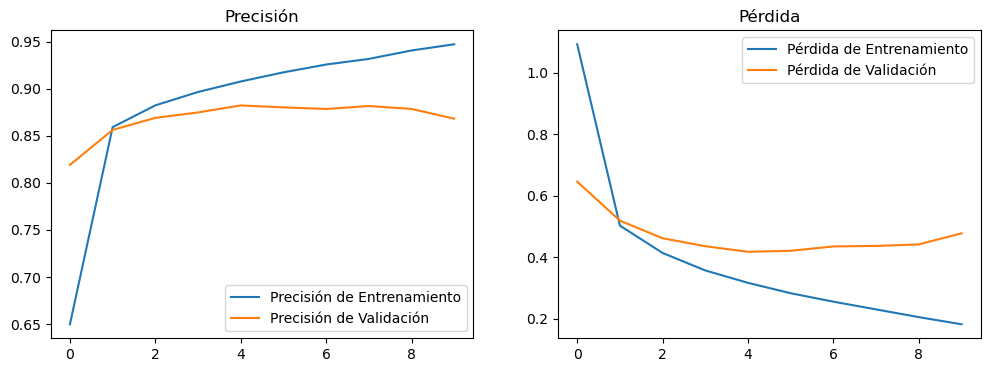

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


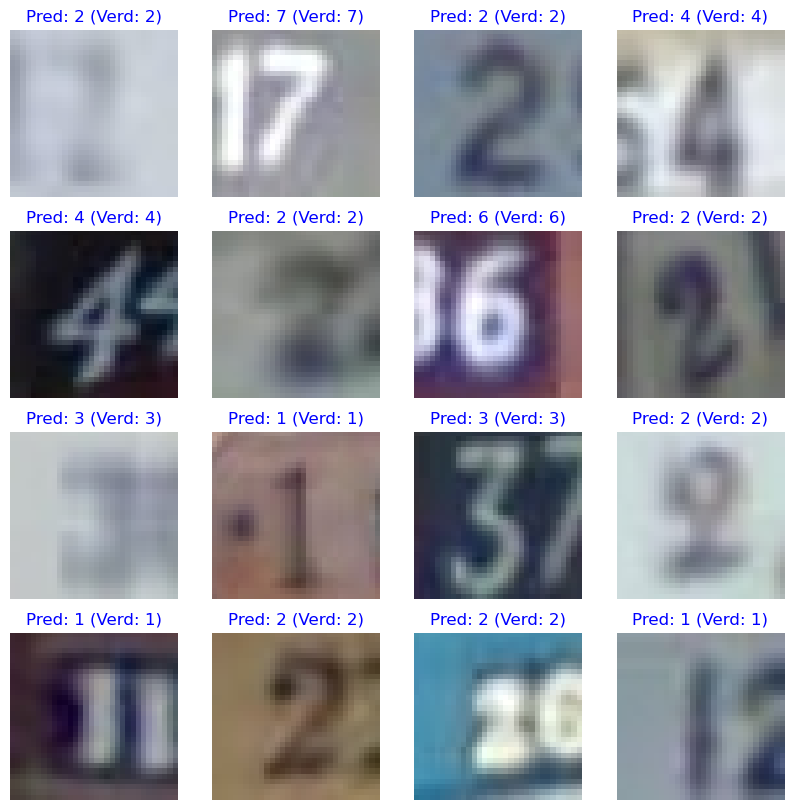

In [6]:
# Construir el modelo con los hiperparámetros óptimos
model = tuner.hypermodel.build(best_hps)

# Combinar los datasets de entrenamiento y validación para el entrenamiento final
ds_train_full = ds_train.concatenate(ds_val)

# Callback para detener el entrenamiento y restaurar los mejores pesos
stop_early_restore = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo final
history = model.fit(ds_train_full,
                    epochs=50,
                    validation_data=ds_test, # Se usa el test set aquí para el early stopping
                    callbacks=[stop_early_restore])

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(ds_test)
print(f'\nPrecisión en el conjunto de prueba: {test_acc:.4f}')

# Funciones para graficar (del cuaderno original)
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
    plt.legend()
    plt.title('Precisión')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de Validación')
    plt.legend()
    plt.title('Pérdida')
    plt.show()

plot_history(history)

# Visualizar predicciones
plt.figure(figsize=(10, 10))
for images, labels in ds_test.take(1):
    predictions = model.predict(images)
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        predicted_label = np.argmax(predictions[i])
        true_label = labels[i]
        color = 'blue' if predicted_label == true_label else 'red'
        plt.title(f"Pred: {predicted_label} (Verd: {true_label})", color=color)
        plt.axis("off")
plt.show()